In [14]:
import os
os.getcwd()
import numpy as np
import sys
import multiprocessing  
# os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA/utils/subspace-clustering-master')
# import cluster
os.chdir('/athena/listonlab/store/amb2022/PCMF/')

saving_dir_fullpath='/athena/listonlab/scratch/amb2022/PCMF/results/'

import mosek
import cvxpy as cp
import time
from itertools import combinations
from admm_utils import prox as cprox
from pcmf import pcmf_full, pcmf_approx_uV
from sklearn.preprocessing import StandardScaler

import argparse

import sys
from datetime import datetime as dt
import pandas as pd
from shutil import copyfile

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict


from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_decomposition import CCA
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment



In [3]:
saving_dir_fullpath='/athena/listonlab/scratch/amb2022/PCMF/results/'

In [ ]:
def centroid_matrix(X,labels):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    keys, counts = np.unique(labels, return_counts=True)
    for k in keys:
        centroid_dict[k] = list() # np.zeros(X.shape[1])
    for i,l in enumerate(labels):
        centroid_dict[l].append(X[i,:])
    for j,k in enumerate(keys):
        centroid_dict[k] = np.mean(np.asarray(centroid_dict[k]), axis=0)
    for i,l in enumerate(labels):
        X_out[i,:] = centroid_dict[l]
    return X_out

def fit_spectral(X, true_clusters, n_clusters, gamma):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors", gamma=0.5).fit(data_in)
#     spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors", gamma=gamma).fit(data_in)
#     spectral_clustering = SpectralClustering(n_clusters = n_clusters, gamma=gamma, random_state=20,\
#                                         assign_labels='discretize',affinity='rbf').fit(data_in)
    labels = spectral_clustering.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)                                                                                                     
    return labels, ari, nmi

from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


In [ ]:
from pcmf import sparse_D, get_weights, centroid_matrix
########### Model Selection functions ############
def cluster_fit(Xhat, num_clusters=2, gamma=2.0,  method='spectral', seed=0, affinity='rbf', assign_labels='discretize'):
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        # clustering = SpectralClustering(n_clusters = num_clusters, gamma=gamma, \
                                        # assign_labels='discretize',affinity='rbf')
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=seed, gamma=gamma, affinity=affinity, assign_labels=assign_labels).fit(Xhat)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=seed)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=num_clusters, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    return clustering.labels_

def select_fit(n_clusts, ics, num_clusters):
    start_num = np.where(np.array(n_clusts)==num_clusters)[0]
    if len(start_num) > 1:
        start_num = start_num[0]
    vals = np.array(ics)[np.where(np.array(n_clusts)==num_clusters)]
    idxs = np.where(vals == np.min(vals))[0]
    if len(idxs) > 1:
        idxs = idxs[0]
    return start_num + idxs

def cluster_path(X_c, Xhat_list, penalty_list, gauss_coef, neighbors, verbose=False, seed=0, affinity='rbf', assign_labels='discretize', method='spectral'):
    '''
    Estimate number of clusters and fit quality at each value of the penalty.
    '''
    ics = []
    n_clusts = []
    centroids = []
    n_clust = 1
    D = sparse_D(X_c.shape[0],X_c.shape[1])
    weights = get_weights(X_c, gauss_coef=gauss_coef, neighbors=neighbors)
    #
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list = penalty_list[notinf_idx]
    Xhat_list = [Xhat_list[i] for i in range(len(Xhat_list)) if i in notinf_idx]
    for i,Xhat in enumerate(Xhat_list):
        penalty = penalty_list[i]
        if n_clust < Xhat.shape[0]:
            out, n_clust, labels, ic = cluster_forwardstep(Xhat, X_c, D, n_clust, penalty, weights, 
                                                            method=method, gamma=gauss_coef, selection='lik', verbose=verbose, seed=seed)
        n_clusts.append(n_clust)
        ics.append(ic)
        centroids.append(out)
    return n_clusts, ics, centroids

from p3ca import convex_clust_df
def cluster_forwardstep(Xhat, X, D, n_clust_previous, penalty, weights, method='spectral', gamma=1.0, selection='bic', verbose=False, seed=0):
    epsilon = penalty
    #
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf', random_state=seed)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous, random_state=seed)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels1 = clustering.labels_
    Xhat1 = centroid_matrix(Xhat, labels1)
    df1 = n_clust_previous + 2
    #df1 = convex_clust_df(Xhat1, penalty, epsilon = epsilon)  
    if np.isnan(df1):
        df1 = 1
    #print('DF1:',df1, n_clust_previous)
    #
    # Cluster on the rows of V with k=n_clust_previous+1 
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous+1, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf', random_state=seed)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous+1, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous+1, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels2 = clustering.labels_
    Xhat2 = centroid_matrix(Xhat, labels2)
    df2 = n_clust_previous + 1 + 2
    #df2 = convex_clust_df(Xhat2, penalty, epsilon = epsilon)      
    if np.isnan(df2):
        df2 = 2
    #print('DF2:',df2,n_clust_previous+1)
    #
    # Check loss for both clusterings
    loglik1 = np.linalg.norm(X - Xhat1, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat1),axis=1))
    loglik2 = np.linalg.norm(X - Xhat2, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1))
    #
    if selection == 'aic':
        ic1 = loglik1 + 2*df1 
        ic2 = loglik2 + 2*df2 
    elif selection == 'bic':
        ic1 = loglik1 + df1*np.log(Xhat.shape[0])
        ic2 = loglik2 + df2*np.log(Xhat.shape[0])
    else:
        ic1 = loglik1
        ic2 = loglik2
    #
    if verbose:
        print("IC1, IC2, Penalty, Penalty Term:",ic1,ic2,penalty,np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1)))
    if np.isnan(ic1):
        ic1 = np.inf
    #
    # Return the better clustering 
    if ic1 >= ic2:
        if verbose:
            print('Num clusters:', n_clust_previous+1)
        return centroid_matrix(Xhat,labels2), n_clust_previous+1, labels2, ic2
    else:
        if verbose:
            print('Num clusters:', n_clust_previous)
        return centroid_matrix(Xhat,labels1), n_clust_previous, labels1, ic1


In [16]:
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


In [85]:
data_path = saving_dir_fullpath+'AISTATS_pcmf_full_SRBCT_genomics_run_run_rank10_gausscoef2.0_neighbors25_rho1.npz'
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_GbmBreastLungCancer_genomics_run_run_rank3_gausscoef2.0_neighbors15_rho1.npz'
data_path = saving_dir_fullpath+'AISTATS_pcmf_full_NCI_genomics_run_run_rank20_gausscoef2.0_neighbors15_rho1.npz'


data_path


'/athena/listonlab/scratch/amb2022/PCMF/results/AISTATS_pcmf_full_NCI_genomics_run_run_rank20_gausscoef2.0_neighbors15_rho1.npz'

In [86]:
list(results.keys())


['problem_rank',
 'pcmf_type',
 'X_c',
 'true_clusters',
 'A',
 'V',
 'U',
 'S',
 'runtime',
 'penalty_list',
 'rho',
 'numba',
 'admm_iters',
 'weights',
 'gauss_coef',
 'neighbors',
 'scale_data',
 'intercept']

In [ ]:
data_path = saving_dir_fullpath+'AISTATS_pcmf_full_GbmBreastLungCancer_genomics_run_run_rank10_gausscoef2.0_neighbors25_rho1.npz'
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_GbmBreastLungCancer_genomics_run_run_rank10_gausscoef2.0_neighbors15_rho1.npz'

# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_NCI_genomics_run_run_rank3_gausscoef2.0_neighbors15_rho1.npz'
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_NCI_genomics_run_run_rank14_gausscoef2.0_neighbors15_rho1.npz'
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_MouseOrgans_genomics_run_run_rank8_gausscoef2.0_neighbors15_rho1.npz'
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_MouseOrgans_genomics_run_run_rank8_gausscoef2.0_neighbors15_rho1.npz'

print(data_path)
# data_path = saving_dir_fullpath+'AISTATS_pcmf_full_NCI_genomics_run_run_rank14_gausscoef2.0_neighbors15_rho1.npz'


results = np.load(data_path, allow_pickle=True)

A_list = results['A']
U_list = results['U']
V_list = results['V']
s_list = results['S']
X_c = results['X_c']
penalty_list = results['penalty_list']
toc = results['runtime']
true_clusters_all = results['true_clusters'] #pd.factorize(results['true_clusters'])

true_clusters =  pd.factorize(results['true_clusters'])[0]
gauss_coeff = results['gauss_coef']

# A_list = []
# for p in range(len(penalty_list)):
#     A_list.append(U_list[p]*V_list[p])
    
print("Cluster types:",np.unique(true_clusters_all))
print("A shape is:",np.asarray(A_list).shape, "U shape is:", np.asarray(U_list).shape, "V shape is:", np.asarray(V_list).shape)
print("Running length PCMF full:", toc)

from p3ca import cluster_metrics

notinf_idx = np.where(penalty_list<np.inf)[0]
v_cluster_metrics = cluster_metrics(np.array(A_list)[notinf_idx,:,:], penalty_list[notinf_idx], true_clusters, c_type='spectral')

end_ind=160
start_ind=5
path_plot(np.flip(np.asarray(A_list)[start_ind:end_ind,:,0:3],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(U_list)[start_ind:end_ind,:,1:2],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(V_list)[start_ind:end_ind,:,1:2],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(s_list)[start_ind:end_ind,:,1:2],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
for i in range(0,160):
    pred_clusters = v_cluster_metrics.cluster_along_path(i=i,c_type='spectral')
#     pred_clusters = cluster_fit(A_list[i], num_clusters=num_clusters, gamma=gauss_coeff, method='spectral')
    conf_mat_ord = confusion_matrix_ordered(pred_clusters,true_clusters)
    np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(acc)
    



/athena/listonlab/scratch/amb2022/PCMF/results/AISTATS_pcmf_full_GbmBreastLungCancer_genomics_run_run_rank10_gausscoef2.0_neighbors25_rho1.npz
Cluster types: ['breast' 'gbm' 'lung']
A shape is: (160, 142, 11931) U shape is: (160, 142, 10) V shape is: (160, 10, 11931)
Running length PCMF full: 4075.2210812568665
0.9436619718309859
0.9577464788732394
0.9647887323943662
0.9577464788732394
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9647887323943662
0.971830985915493
0.9436619718309859
0.9647887323943662
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9577464788732394
0.9577464788732394
0.9577464788732394
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9577464788732394
0.9647887323943662
0.9647887323943662
0.9577464788732394
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9436619718309859
0.9507042253521126
0.9507042253521126
0.9577464788732394
0.9507042253521126
0.9436619718309859
0.94

In [88]:
# Xhat_list = []
# for i in range(len(penalty_list)):
#     Xhat_list.append(U_list[i] * V_list[i])
    
Xhat_list = A_list
num_clusters = len(np.unique(true_clusters))

print(len(Xhat_list))
print(len(np.unique(true_clusters_all)))


160
14


In [89]:
# pred_clusters = cluster_fit(Xhat_list[i], num_clusters=num_clusters, gamma=gauss_coeff)

# A_list[i].shape

In [92]:
def cluster_fit(Xhat, num_clusters=2, gamma=2.0,  method='spectral'):
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = num_clusters, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf', random_state=1234)
#         clustering = SpectralClustering(n_clusters=num_clusters, gamma=gamma).fit(Xhat)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=num_clusters, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    return clustering.labels_

from p3ca import cluster_metrics

notinf_idx = np.where(penalty_list<np.inf)[0]
v_cluster_metrics = cluster_metrics(np.array(Xhat_list)[notinf_idx,:,:], penalty_list[notinf_idx], true_clusters, c_type='spectral')

for i in range(0,160):
    pred_clusters = v_cluster_metrics.cluster_along_path(i=i,c_type='kmeans')
#     pred_clusters = cluster_fit(Xhat_list[i], num_clusters=num_clusters, gamma=gauss_coeff)
    conf_mat_ord = confusion_matrix_ordered(pred_clusters,true_clusters)
    np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(acc)
    


0.4375
0.390625
0.421875
0.40625
0.46875
0.375
0.390625
0.390625
0.40625
0.421875
0.421875
0.34375
0.34375
0.34375
0.359375
0.359375
0.359375
kmeans fail


ValueError: Found input variables with inconsistent numbers of samples: [3, 64]

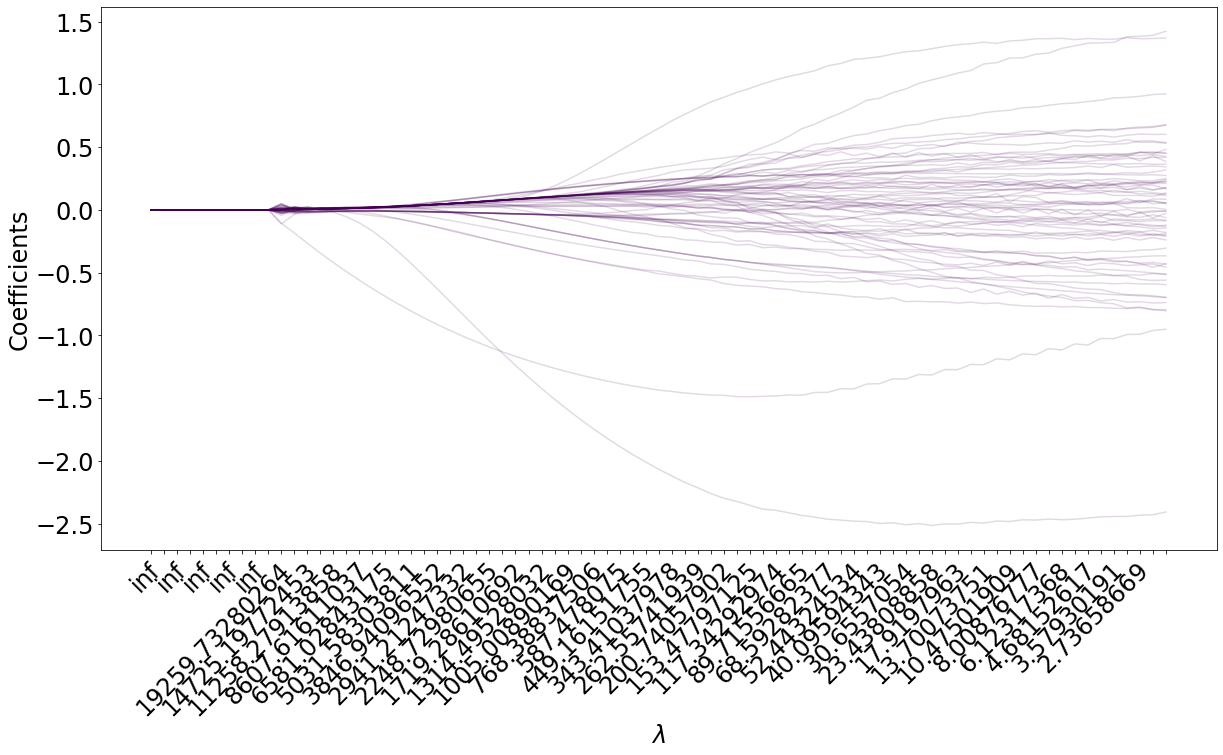

In [137]:
from pcmf import path_plot
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

end_ind=80
path_plot(np.flip(np.asarray(Xhat_list)[start_ind:end_ind,:,1:2],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(U_list)[start_ind:end_ind,:, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])

# path_plot(np.reshape(np.flip(np.asarray(V_list)[start_ind:end_ind,0:1, :],axis=2),(160,6831,1)), penalty_list[start_ind:end_ind], plot_range=[0,-1])


# start_ind=0
# end_ind=160
# V_list = A_list
# # path_plot(np.flip(np.asarray(Xhat_centroids)[:,true_clusters==0, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(V_list)[start_ind:end_ind,true_clusters==0, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# plt.xlabel("V ")
# plt.ylabel("C1 Estimates")
# # plt.ylim([-0.03,0.03])

# # path_plot(np.flip(np.asarray(Xhat_centroids)[:,true_clusters==1, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(V_list)[start_ind:end_ind,true_clusters==1, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# plt.xlabel("V ")
# plt.ylabel("C2 Estimates")
# # plt.ylim([-0.03,0.03])

# # path_plot(np.flip(np.asarray(Xhat_centroids)[:,true_clusters==2, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(V_list)[start_ind:end_ind,true_clusters==2, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# plt.xlabel("V ")
# plt.ylabel("C3 Estimates")
# # plt.ylim([-0.03,0.03])

# # path_plot(np.flip(np.asarray(Xhat_centroids)[:,true_clusters==3, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# path_plot(np.flip(np.asarray(V_list)[start_ind:end_ind,true_clusters==3, -1:],axis=2), penalty_list[start_ind:end_ind], plot_range=[0,-1])
# plt.xlabel("V ")
# plt.ylabel("C4 Estimates")
# # plt.ylim([-0.03,0.03])



In [125]:
.shape


(160, 6831, 1)

In [129]:
Xhat_list[1].shape

(64, 6831)